In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
import time
from parametric_pde_find import *

fontsize = 20

path_to_data = '/home/samuel/Dropbox (uwamath)/ibpm-master/Cylinder_new/output_2/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
W = np.load('../../fine_timestep_multi_reynolds/W.npy')   # vorticity
U = np.load('../../fine_timestep_multi_reynolds/U.npy')   # x-component of velocity
V = np.load('../../fine_timestep_multi_reynolds/V.npy')   # y-component of velocity

steps = 1001
n = 449
m = 199

dt = 0.02
dx = 0.02
dy = 0.02

uw_x_true = -np.ones(steps)
vw_y_true = -np.ones(steps)
w_xx_true = np.hstack([np.ones(501)/100, np.ones(500)/75])
w_yy_true = np.hstack([np.ones(501)/100, np.ones(500)/75])

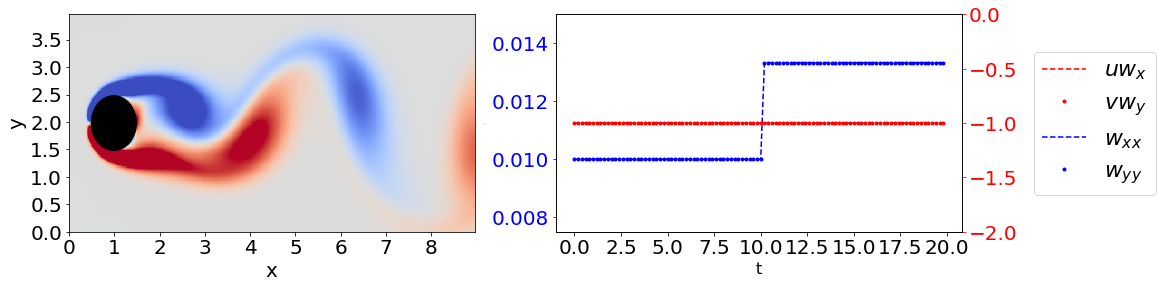

In [3]:
# plot the data
xx, yy = meshgrid(
    np.arange(449)*dx,
    np.arange(199)*dy)

figure(figsize = (16,4))

ax = subplot(1,2,1)
pcolor(xx,yy,W[:,:,125].T,cmap='coolwarm', vmin = -2, vmax = 2)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
ylabel('y', fontsize = fontsize)
ax.add_artist(Circle((0.99,1.98), 0.5, color='k'))
ax.set_xlim([0,448*dx])

ax1 = subplot(1,2,2)

ax1.plot(10*np.arange(100)*dt,w_xx_true[10*np.arange(100)], 'b--')
ax1.plot(10*np.arange(100)*dt,w_yy_true[10*np.arange(100)], 'b.')
ax1.set_xlabel('t', fontsize = 16)
ax1.set_ylim([0.0075,0.015])

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'$\xi(t)$', color='b', fontsize = 0)
ax1.tick_params('y', colors='b', labelsize = fontsize)
ax1.tick_params('x', labelsize = fontsize)

ax2 = ax1.twinx()

ax2.plot(10*np.arange(100)*dt,uw_x_true[10*np.arange(100)], 'r--', label = '$uw_x$')
ax2.plot(10*np.arange(100)*dt,vw_y_true[10*np.arange(100)], 'r.', label = '$vw_y$')

ax2.plot(10*np.arange(100)*dt,w_xx_true[10*np.arange(100)]+5, 'b--', label = '$w_{xx}$')
ax2.plot(10*np.arange(100)*dt,w_yy_true[10*np.arange(100)]+5, 'b.', label = '$w_{yy}$')

ax2.set_ylim([-2,0])

ax2.tick_params('y', colors='r', labelsize = fontsize)

# fig.tight_layout()

legend(loc='center left', bbox_to_anchor=(1.15, 0.5), fontsize = fontsize+2)

In [4]:
# Cut out the portion of the data before the cylinder
xmin = 100
xmax = 425
ymin = 5
ymax = 194

n = xmax-xmin
m = ymax-ymin

In [5]:
R = 500
interpolation_points = np.random.choice(n*m, R)
P_xy = [(int((p-p%m)/m), p%m) for p in interpolation_points]

(0, 199)

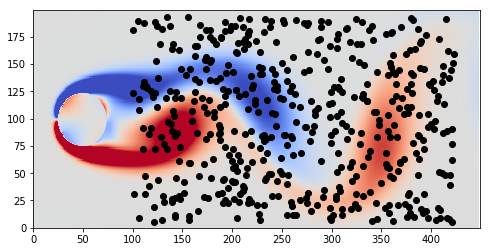

In [6]:
# plot the data
figure(figsize=(8,4))
xx, yy = meshgrid(
    np.arange(449),
    np.arange(199))
pcolor(xx,yy,W[:,:,10].T,cmap='coolwarm', vmin = -2, vmax = 2)

scatter([p[0]+xmin for p in P_xy], [p[1]+ymin for p in P_xy], color = 'k')
xlim([0,449])
ylim([0,199])

In [7]:
num_points = R*steps
points = [[p[0]+xmin,p[1]+ymin] for p in P_xy]

# Take up to second order derivatives.
w = np.zeros((num_points,1))
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
wt = np.zeros((num_points,1))
wx = np.zeros((num_points,1))
wy = np.zeros((num_points,1))
wxx = np.zeros((num_points,1))
wxy = np.zeros((num_points,1))
wyy = np.zeros((num_points,1))

p = 0

for t in range(steps):
    for [x,y] in points:
        
        w[p] = W[x,y,t]
        u[p] = U[x,y,t]
        v[p] = V[x,y,t]

        if t == 0: wt[p] = (W[x,y,t+1] - W[x,y,t])/(dt)
        elif t == steps-1: wt[p] = (W[x,y,t] - W[x,y,t-1])/(dt)
        else: wt[p] = (W[x,y,t+1] - W[x,y,t-1])/(2*dt)

        wx[p] = (W[x+1,y,t] - W[x-1,y,t])/(2*dx)
        wy[p] = (W[x,y+1,t] - W[x,y-1,t])/(2*dy)

        wxx[p] = (W[x+1,y,t] - 2*w[p] + W[x-1,y,t])/(dx**2)
        wxy[p] = ((W[x+1,y+1,t] - W[x-1,y+1,t])/(2*dx) - (W[x+1,y-1,t] - W[x-1,y-1,t])/(2*dx))/(2*dy)
        wyy[p] = (W[x,y+1,t] - 2*w[p] + W[x,y-1,t])/(dy**2)
        
        p = p+1

In [8]:
X_data = np.hstack([w,u,v])
X_ders = np.hstack([np.ones((num_points,1)), wx, wy, wxx, wxy, wyy])
X_ders_descr = ['','w_{x}', 'w_{y}','w_{xx}','w_{xy}','w_{yy}']
Theta, description = build_Theta(X_data, X_ders, X_ders_descr, 2, data_description = ['w','u','v'])
wt = wt.reshape(steps*R,1)

In [9]:
i_uw_x = [i for i in range(len(description)) if description[i] == 'uw_{x}'][0]
i_vw_y = [i for i in range(len(description)) if description[i] == 'vw_{y}'][0]
i_w_xx = [i for i in range(len(description)) if description[i] == 'w_{xx}'][0]
i_w_yy = [i for i in range(len(description)) if description[i] == 'w_{yy}'][0]
xi_true = np.zeros((len(description),steps))
xi_true[i_uw_x,:] = uw_x_true
xi_true[i_vw_y,:] = vw_y_true
xi_true[i_w_xx,:] = w_xx_true
xi_true[i_w_yy,:] = w_yy_true

In [10]:
sample_timesteps = np.arange(1,100)*10
Theta_grouped = [(Theta[j*R:(j+1)*R,:]) for j in sample_timesteps]
wt_grouped = [wt[j*R:(j+1)*R] for j in sample_timesteps]

MSE:  5.87472589212e-09


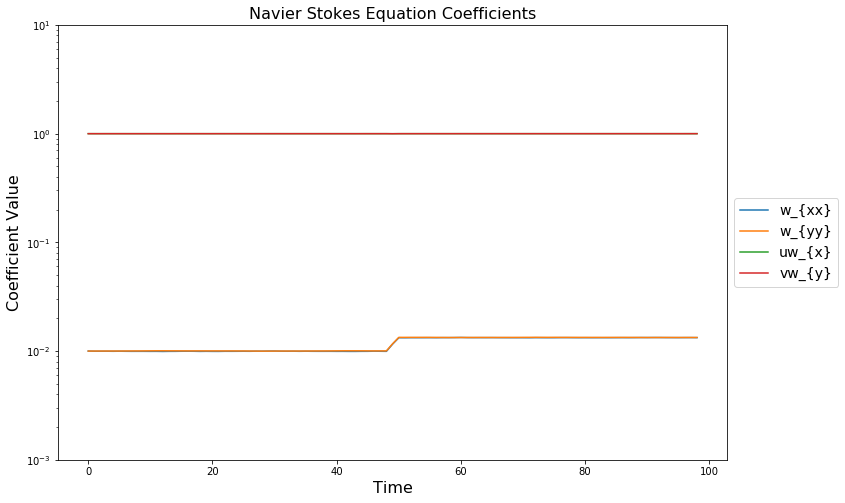

In [11]:
# Solve for coefficients using SGTR
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, wt_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        semilogy(abs(xi[j,:]), label = description[j])

title('Navier Stokes Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
ylim([0.001,10])

mse_clean_sgtr = Norm(xi-xi_true[:,sample_timesteps])**2/(m*len(description))
print('MSE: ', mse_clean_sgtr)

(array([-569900., -569850., -569800., -569750., -569700., -569650.,
        -569600., -569550.]), <a list of 8 Text yticklabel objects>)

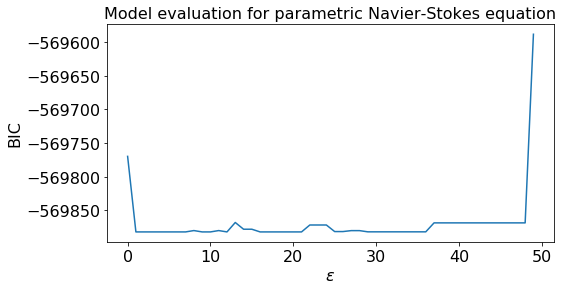

In [12]:
figure(figsize = (8,4))

plot(Losses)

title('Model evaluation for parametric Navier-Stokes equation', fontsize = 16)
ylabel('BIC', fontsize = 16)
xlabel(r'$\epsilon$', fontsize = 16)
xticks(fontsize = 16)
yticks(fontsize = 16)

MSE:  5.87472589212e-09


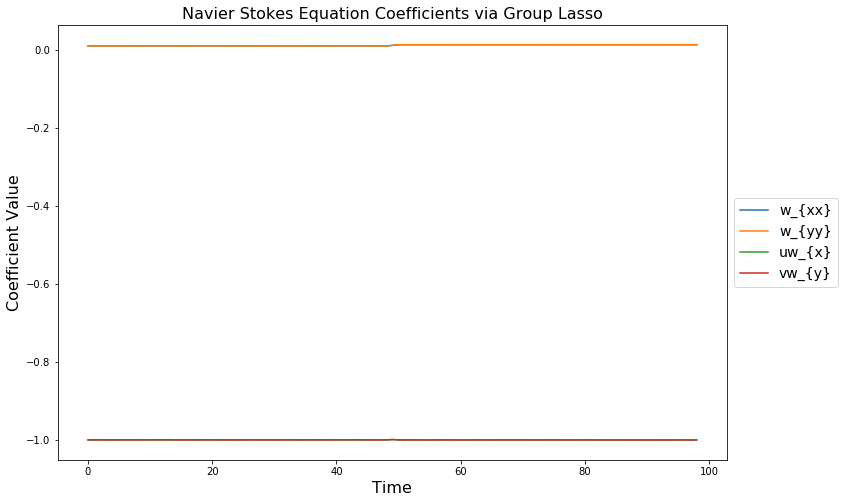

In [13]:
# Same thing with group lasso
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(len(sample_timesteps))] for j in range(D)]
Xi_lasso,Lam_lasso,Losses_lasso,History_lasso = TrainGroupLasso(Theta_grouped, wt_grouped, groups)
xi_lasso = Xi_lasso[np.argmin(Losses_lasso)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso.shape[0]): 
    if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
        plot(xi_lasso[j,:], label = description[j])

title('Navier Stokes Equation Coefficients via Group Lasso', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_lasso = Norm(xi_lasso-xi_true[:,sample_timesteps])**2/(m*len(description))
print('MSE: ', mse_clean_lasso)

In [14]:
# Cut out the portion of the data before the cylinder
xmin = 100
xmax = 425
ymin = 7
ymax = 192
n,m,steps = W.shape

# add in artificial noise
W = W + 0.01*np.std(W[xmin:xmax,ymin:ymax,:])*np.random.randn(n,m,steps)
U = U + 0.01*np.std(U[xmin:xmax,ymin:ymax,:])*np.random.randn(n,m,steps)
V = V + 0.01*np.std(V[xmin:xmax,ymin:ymax,:])*np.random.randn(n,m,steps)

In [15]:
PsiW, SigmaW, VtW = np.linalg.svd(W.reshape(n*m, steps),full_matrices = False)
PsiU, SigmaU, VtU = np.linalg.svd(U.reshape(n*m, steps),full_matrices = False)
PsiV, SigmaV, VtV = np.linalg.svd(V.reshape(n*m, steps),full_matrices = False)

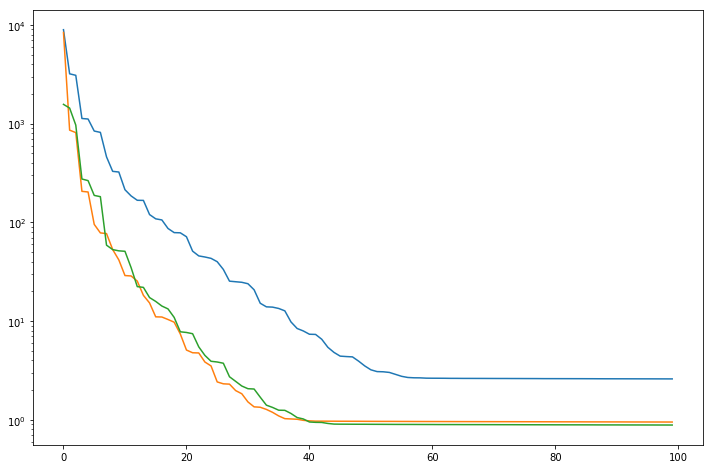

In [16]:
semilogy(SigmaW[:100])
semilogy(SigmaU[:100])
semilogy(SigmaV[:100])

In [17]:
rw = 57
ru = 45
rv = 45
W = PsiW[:,:rw].dot(np.diag(SigmaW[:rw])).dot(VtW[:rw,:]).reshape(n,m,steps)
U = PsiU[:,:ru].dot(np.diag(SigmaU[:ru])).dot(VtU[:ru,:]).reshape(n,m,steps)
V = PsiV[:,:rv].dot(np.diag(SigmaV[:rv])).dot(VtV[:rv,:]).reshape(n,m,steps)

In [18]:
Wn = W[xmin:xmax,ymin:ymax,:]
Un = U[xmin:xmax,ymin:ymax,:]
Vn = V[xmin:xmax,ymin:ymax,:]
n,m,steps = Wn.shape

In [19]:
R = 1000
interpolation_points = np.random.choice(n*m, R)
P_xy = [(int((p-p%m)/m), p%m) for p in interpolation_points]

(0, 199)

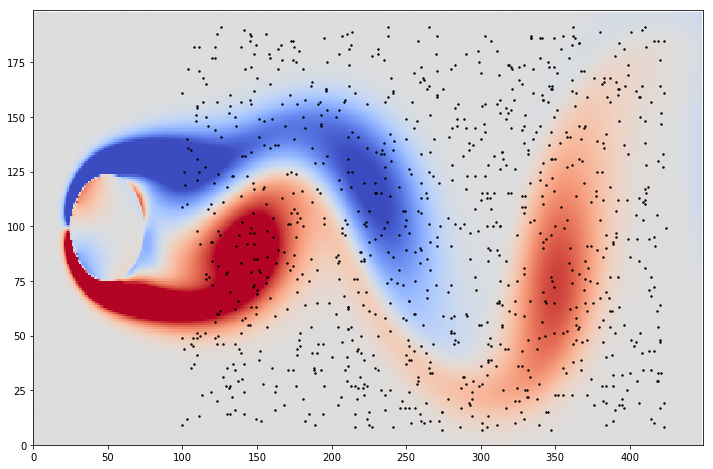

In [20]:
# plot the data
xx, yy = meshgrid(
    np.arange(449),
    np.arange(199))
pcolor(xx,yy,W[:,:,10].T,cmap='coolwarm', vmin = -2, vmax = 2)

scatter([p[0]+xmin for p in P_xy], [p[1]+ymin for p in P_xy], color = 'k', s = 2)
xlim([0,449])
ylim([0,199])

In [21]:
boundary = 7
Nx = 15
N = 15
deg = 5
deg_x = 5
sample_timesteps = np.arange(1,100)*10

num_points = R*len(sample_timesteps)
points = [[p[0]+xmin,p[1]+ymin] for p in P_xy]

# Take up to second order derivatives.
w = np.zeros((num_points,1))
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
wt = np.zeros((num_points,1))
wx = np.zeros((num_points,1))
wy = np.zeros((num_points,1))
wxx = np.zeros((num_points,1))
wxy = np.zeros((num_points,1))
wyy = np.zeros((num_points,1))

p = 0

start = time.time()

for t in sample_timesteps:
    for [x,y] in points:
    
        w[p] = W[x,y,t]
        u[p] = U[x,y,t]
        v[p] = V[x,y,t]
                
        t_lower = t-int((N-1)/2)
        t_upper = t+int((N+1)/2)
        x_lower = x-int((Nx-1)/2)
        x_upper = x+int((Nx+1)/2)
        y_lower = y-int((N-1)/2)
        y_upper = y+int((N+1)/2)

        wt[p] = PolyDiffPoint(W[x,y,t_lower:t_upper], np.arange(N)*dt, deg, 1)[0]

        x_diff = PolyDiffPoint(W[x_lower:x_upper,y,t], np.arange(Nx)*dx, deg_x, 2)
        y_diff = PolyDiffPoint(W[x,y_lower:y_upper,t], np.arange(N)*dy, deg, 2)
        wx[p] = x_diff[0]
        wy[p] = y_diff[0]

        x_diff_yp = PolyDiffPoint(W[x_lower:x_upper,y+1,t], np.arange(Nx)*dx, deg_x, 2)
        x_diff_ym = PolyDiffPoint(W[x_lower:x_upper,y-1,t], np.arange(Nx)*dx, deg_x, 2)

        wxx[p] = x_diff[1]
        wxy[p] = (x_diff_yp[0]-x_diff_ym[0])/(2*dy)
        wyy[p] = y_diff[1]
        
        p = p+1
        
    print('\rTimestep', int(p/R), 'of', len(sample_timesteps), 'eta:', \
          int((len(sample_timesteps)-p/R)*(time.time()-start)*R/p), end = '')
    
print('\rCompleted differentiation.  Elapsed time:', int(time.time()-start), 's')

Completed differentiation.  Elapsed time: 150 s


In [22]:
X_data = np.hstack([w,u,v])
X_ders = np.hstack([np.ones((num_points,1)), wx, wy, wxx, wxy, wyy])
X_ders_descr = ['','w_{x}', 'w_{y}','w_{xx}','w_{xy}','w_{yy}']
Thetan, description = build_Theta(X_data, X_ders, X_ders_descr, 2, data_description = ['w','u','v'])
wtn = wt.reshape(len(sample_timesteps)*R,1)

In [23]:
Thetan_grouped = [(Thetan[j*R:(j+1)*R,:]) for j in range(len(sample_timesteps))]
wtn_grouped = [wtn[j*R:(j+1)*R] for j in range(len(sample_timesteps))]

MSE:  1.1591401855e-07


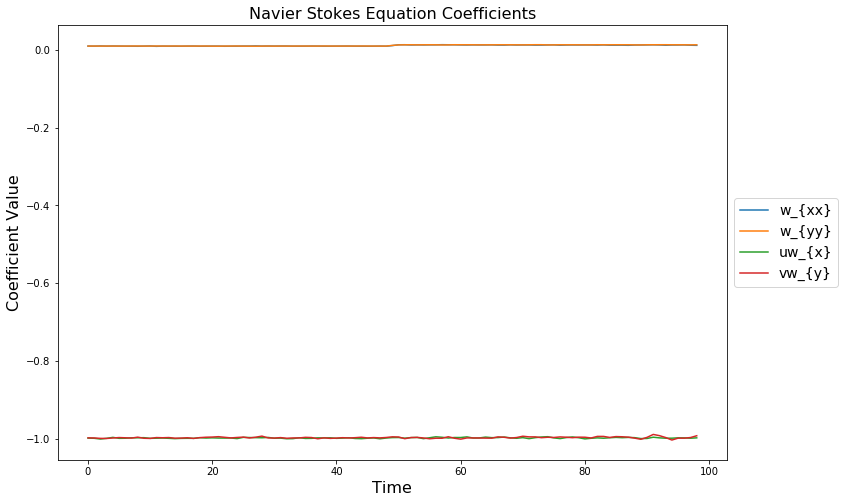

In [24]:
Xi_n,Tol_n,Losses_n = TrainSGTRidge(Thetan_grouped, wtn_grouped)
xi_n = Xi_n[np.argmin(Losses_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = description[j])

title('Navier Stokes Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_n-xi_true[:,sample_timesteps])**2/(m*len(description))
print('MSE: ', mse_noise_sgtr)

MSE:  1.1591401855e-07


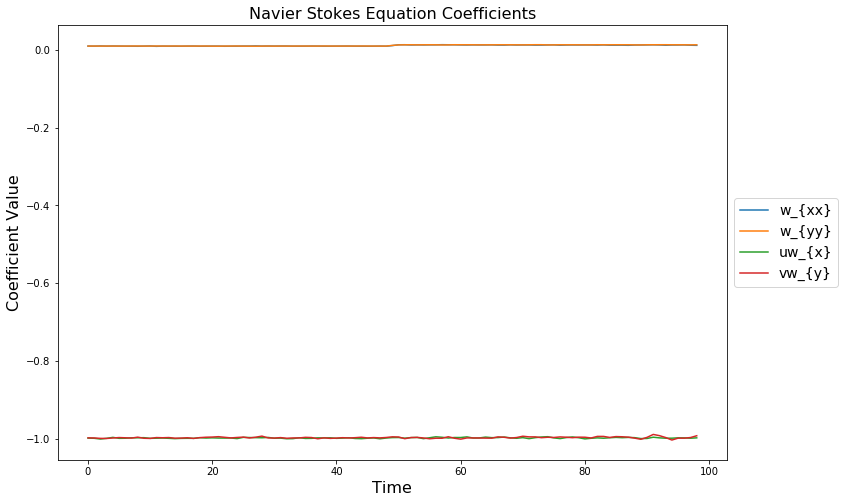

In [25]:
D = Thetan_grouped[0].shape[1]
groups = [[j+D*i for i in range(len(sample_timesteps))] for j in range(D)]

Xi_lasso_n,Lam_lasso_n,Losses_lasso_n,History_lasso_n = TrainGroupLasso(Thetan_grouped, wtn_grouped, groups)
xi_lasso_n = Xi_lasso_n[np.argmin(Losses_lasso_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso_n.shape[0]): 
    if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
        plot(xi_lasso_n[j,:], label = description[j])

title('Navier Stokes Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_lasso = Norm(xi_lasso_n-xi_true[:,sample_timesteps])**2/(m*len(description))
print('MSE: ', mse_noise_lasso)

In [26]:
i_w_xx = [i for i in range(60) if description[i] == 'w_{xx}'][0]
i_w_yy = [i for i in range(60) if description[i] == 'w_{yy}'][0]
i_uw_x = [i for i in range(60) if description[i] == 'uw_{x}'][0]
i_vw_y = [i for i in range(60) if description[i] == 'vw_{y}'][0]

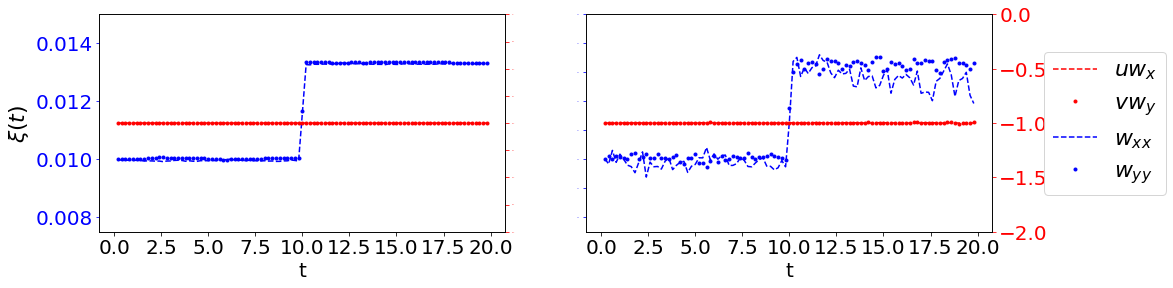

In [27]:
fig, ax1 = plt.subplots(figsize = (16,4))

####################################################################################
ax1 = subplot(1,2,1)

ax1.plot(sample_timesteps*dt,xi[i_w_xx,:], 'b--', label = description[i_w_xx])
ax1.plot(sample_timesteps*dt,xi[i_w_yy,:], 'b.', label = description[i_w_yy])
ax1.set_xlabel('t', fontsize = fontsize)
ylim([0.0075,0.015])

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'$\xi(t)$', fontsize = fontsize+2)
ax1.tick_params('y', colors='b', labelsize = fontsize)
ax1.tick_params('x', labelsize = fontsize)

ax2 = ax1.twinx()

ax2.plot(sample_timesteps*dt,xi[i_uw_x,:], 'r--', label = description[i_uw_x])
ax2.plot(sample_timesteps*dt,xi[i_vw_y,:], 'r.', label = description[i_vw_y])
ax2.set_ylim([-2,0])

# ax2.set_yticks([])
ax2.tick_params('y', colors='r', labelsize = 0)

####################################################################################

ax1 = subplot(1,2,2)

ax1.plot(sample_timesteps*dt,xi_n[i_w_xx,:], 'b--', label = description[i_w_xx])
ax1.plot(sample_timesteps*dt,xi_n[i_w_yy,:], 'b.', label = description[i_w_yy])
ax1.set_xlabel('t', fontsize = fontsize)
ax1.set_ylim([0.0075,0.015])

# Make the y-axis label, ticks and tick labels match the line color.
ax1.tick_params('y', colors='b', labelsize = 0)
ax1.tick_params('x', labelsize = fontsize)

ax2 = ax1.twinx()

ax2.plot(sample_timesteps*dt,xi_n[i_uw_x,:], 'r--', label = '$'+description[i_uw_x]+'$')
ax2.plot(sample_timesteps*dt,xi_n[i_vw_y,:], 'r.', label = '$'+description[i_vw_y]+'$')

ax2.plot(sample_timesteps*dt,xi_n[i_w_xx,:]+5, 'b--', label = '$'+description[i_w_xx]+'$')
ax2.plot(sample_timesteps*dt,xi_n[i_w_yy,:]+5, 'b.', label = '$'+description[i_w_yy]+'$')

ax2.set_ylim([-2,0])

ax2.tick_params('y', colors='r', labelsize = fontsize)

# fig.tight_layout()

legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize = fontsize+2)